# Transmon Floquet analysis

Here we perform a Floquet simulation of a transmon subject to off-resonant drives. We extract as a function of drive strength and drive frequency the probability of ionization for the two qubit states. We then compare the 2D plots (with the x and y axes drive frequency and induced ac stark shift on the qubit, respectively and the z axis ionization probability) with Blais-style branch crossing plots, which identify the states the qubit states leak to.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import scqubits as scq
from cycler import cycler

import floquet as ft


color_cycler = plt.rcParams['axes.prop_cycle']
ls_cycler = cycler(ls=['-', '--', '-.', ':'])
alpha_cycler = cycler(alpha=[1.0, 0.6, 0.2])
color_ls_alpha_cycler = alpha_cycler * ls_cycler * color_cycler

/Users/danielweiss/anaconda3/envs/floquet_pkg/lib/python3.10/site-packages/qutip/__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


## Define simulation parameters

In [10]:
filepath = ft.generate_file_path('h5py', 'transmon_floquet', 'out')

# drive frequencies to scan over
omega_d_linspace = 2.0 * np.pi * np.linspace(7.5, 10.0, 120)
# induced ac stark shifts to scan over
chi_ac_linspace = 2.0 * np.pi * np.linspace(0.0, 0.1, 59)

num_states = 20
qubit_params = {'EJ': 20.0, 'EC': 0.2, 'ng': 0.25, 'ncut': 41}
tmon = scq.Transmon(**qubit_params, truncated_dim=num_states)
state_indices = [0, 1]  # get data for ground and first excited states

# express operators in eigenbasis of transmon
hilbert_space = scq.HilbertSpace([tmon])
hilbert_space.generate_lookup()
evals = hilbert_space['evals'][0][0:num_states]
H0 = 2.0 * np.pi * qt.Qobj(np.diag(evals - evals[0]))
H1 = hilbert_space.op_in_dressed_eigenbasis(tmon.n_operator)

# to achieve same range of chi_ac for the various drive frequencies,
# need to drive at different strengths
chi_to_amp = ft.ChiacToAmp(H0, H1, state_indices, omega_d_linspace)
# resulting array has shape (a,w), where a is amplitude and w is frequency
amp_linspace = chi_to_amp.amplitudes_for_omega_d(chi_ac_linspace)

drive_parameters = ft.DriveParameters(
    omega_d_values=omega_d_linspace, drive_amplitudes=amp_linspace
)

options = ft.Options(
    fit_range_fraction=0.5,  # split the fit into segments based on this fraction
    floquet_sampling_time_fraction=0.0,  # what part of the period to look at
    fit_cutoff=4,  # polynomial cutoff
    overlap_cutoff=0.8,  # cutoff for the excluding from the fit
    nsteps=30_000,  # qutip integration parameter
    num_cpus=6,
    save_floquet_mode_data=False,  # don't save floquet modes
)

In [11]:
floquet_analysis = ft.floquet_analysis(
    H0,
    H1,
    drive_parameters=drive_parameters,
    state_indices=state_indices,
    options=options,
)
data_vals = floquet_analysis.run(filepath=filepath)

Running floquet simulation with parameters: 
fit_range_fraction: 0.5
floquet_sampling_time_fraction: 0.0
fit_cutoff: 4
overlap_cutoff: 0.8
nsteps: 30000
num_cpus: 6
save_floquet_mode_data: False
omega_d_values: [47.1238898  47.2558895  47.38788919 47.51988888 47.65188857 47.78388826
 47.91588795 48.04788764 48.17988733 48.31188703 48.44388672 48.57588641
 48.7078861  48.83988579 48.97188548 49.10388517 49.23588487 49.36788456
 49.49988425 49.63188394 49.76388363 49.89588332 50.02788301 50.1598827
 50.2918824  50.42388209 50.55588178 50.68788147 50.81988116 50.95188085
 51.08388054 51.21588023 51.34787993 51.47987962 51.61187931 51.743879
 51.87587869 52.00787838 52.13987807 52.27187777 52.40387746 52.53587715
 52.66787684 52.79987653 52.93187622 53.06387591 53.1958756  53.3278753
 53.45987499 53.59187468 53.72387437 53.85587406 53.98787375 54.11987344
 54.25187314 54.38387283 54.51587252 54.64787221 54.7798719  54.91187159
 55.04387128 55.17587097 55.30787067 55.43987036 55.57187005 55

## Plot the probability of nonlinear transitions

In [12]:
data_dict, param_dict = ft.extract_info_from_h5(filepath)

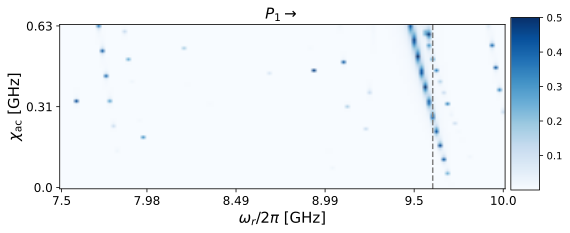

In [13]:
tmon_idx = 1  # Plot leakage probability for |e>. Try 0 for |g>
omega_d_idx = 100  # Drive frequency where we take a linecut

plot_data = np.clip(
    1 - data_dict['displaced_state_overlaps'][:, :, tmon_idx].T ** 2, 0.0, 0.5
)
fig, ax = plt.subplots(figsize=(8, 8))
xticks = param_dict['omega_d_values'] / (2.0 * np.pi)
yticks = chi_ac_linspace
num_x_pts = len(xticks)
num_y_pts = len(yticks)
im = plt.imshow(
    plot_data,
    origin='lower',
    cmap='Blues',
    aspect=0.75,  # 2.3, #0.15,
    interpolation='none',
)
plt.axvline(omega_d_idx, color='grey', ls='--')
ax.set_title(f'$P_{tmon_idx}$' + r'$\rightarrow$', fontsize=15)
xticklabel_locations = np.linspace(0, num_x_pts - 1, 6, dtype=int)
ax.set_xticks(xticklabel_locations)
ax.set_xticklabels(
    np.array(np.around(xticks[xticklabel_locations], decimals=2), dtype=str),
    fontsize=12,
)
yticklabel_locations = np.linspace(0, num_y_pts - 1, 3, dtype=int)
ax.set_yticks(yticklabel_locations)
ax.set_yticklabels(
    np.array(np.around(yticks[yticklabel_locations], decimals=2), dtype=str),
    fontsize=12,
)
ax.set_ylabel(r'$\chi_{\rm ac}$ [GHz]', fontsize=15)
ax.set_xlabel(r'$\omega_r/2\pi$ [GHz]', fontsize=15)
cax = plt.axes([0.91, 0.35, 0.05, 0.3])
cbar = plt.colorbar(im, cax=cax)
plt.show()

## Now lets compare with the Blais branch plots

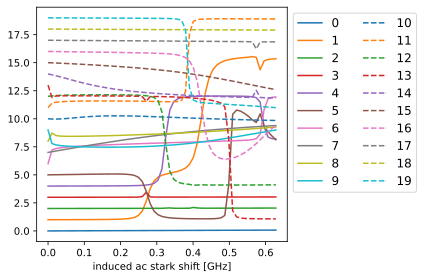

In [14]:
fig, ax = plt.subplots(figsize=(6, 4))
for curve_idx, sty in zip(range(param_dict['hilbert_dim']), color_ls_alpha_cycler):
    plt.plot(
        chi_ac_linspace,
        data_dict['avg_excitation'][omega_d_idx, :, curve_idx],
        label=curve_idx,
        **sty,
    )
ax.set_xlabel('induced ac stark shift [GHz]')
ax.legend(fontsize=12, ncol=2, loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

We see that the scar plots and Blais plots both predict two locations (in drive power) where the first excited state can ionize. Lets look at the quasienergies to confirm that the quasienergies have an avoided crossing for the states experiencing branch crossings

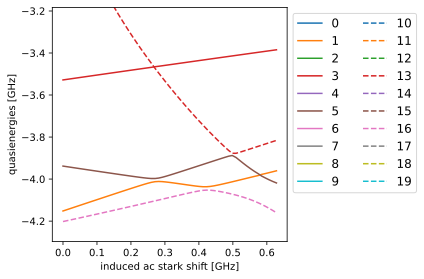

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))
for curve_idx, sty in zip(range(param_dict['hilbert_dim']), color_ls_alpha_cycler):
    plt.plot(
        chi_ac_linspace,
        data_dict['quasienergies'][omega_d_idx, :, curve_idx] / 2 / np.pi,
        label=curve_idx,
        **sty,
    )
ax.set_xlabel('induced ac stark shift [GHz]')
ax.set_ylabel('quasienergies [GHz]')
ax.legend(fontsize=12, ncol=2, loc='upper left', bbox_to_anchor=(1, 1))
ax.set_ylim(-27 / 2 / np.pi, -20 / 2 / np.pi)
plt.tight_layout()
plt.show()